## Loss Function

The optimizers we implemented in last notebook iteratively updates the model's parameters using the gradients(i.e. the partial derivatives of the loss function with respect to each model parameters). 

The loss function measures the dissimilarity between our model's output and the ground truth. If we say gradient is the direction of optimization, then loss function is the source of that direction. Therefore, we would always want to design/choose loss function that acurately describes the discrepency between model's output and ground truth.  

There are quite a few options we have with loss functions when working with Tensorflow. We will demostrate how using the previous regression example. 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from matplotlib import pyplot
%matplotlib inline

In [2]:
true_weights = tf.constant(np.array(range(10)), dtype=tf.float32)[:, tf.newaxis]
x = tf.constant(tf.random.uniform((65535, 10)), dtype=tf.float32)
y = tf.constant(x @ true_weights, dtype=tf.float32)
optimizer = tf.keras.optimizers.Adam(lr=1e-2)

class Linear(tf.keras.layers.Layer):
    def __init__(self, units, use_bias=True, relu_activ=False, **kwargs):
        super(Linear, self).__init__(**kwargs)
        self.units = units
        self.use_bias = use_bias
        self.relu_activ = relu_activ
        
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units))
        if self.use_bias:
            self.b = self.add_weight(shape=(self.units), initializer="zeros")
        super().build(input_shape)
        
    @tf.function
    def call(self, x):
        output = tf.matmul(x, self.w)
        if self.use_bias:
            output += self.b
        if self.relu_activ:
            output = tf.maximum(tf.cast(0, dtype=x.dtype), output)
        return output
    
    
class LinearModel(tf.keras.Model):
    def __init__(self, num_units, use_bias=True, **kwargs):
        super(LinearModel, self).__init__(**kwargs)
        num_layers = len(num_units)
        self.model = [Linear(units, use_bias, relu_activ= i != num_layers) for i, units in enumerate(num_units, 1)]
    
    def call(self, x):
        for layer in self.model:
            x = layer(x)
        return x
    
    
def train(model, criterion, optimizer, batch_size=1024, num_epochs=30, record_steps=1):
    n = tf.shape(x).numpy()[0]
    steps_per_epoch = n // batch_size
    
    history = []
    for it in range(num_epochs):
        for bt in tqdm(range(steps_per_epoch), 
                       desc='Training epoch {}'.format(it + 1), 
                       leave=False):
            sample_indices = tf.convert_to_tensor(np.random.choice(range(n), batch_size))
            x_batch, y_batch = tf.gather(x, sample_indices), tf.gather(y, sample_indices)
            # forward pass to calculate loss
            with tf.GradientTape() as tape:
                loss = criterion(y_batch, model(x_batch))

            # backward pass to calculate gradients
            gradients = tape.gradient(loss, model.variables)
            
            # use optimizer object to do update
            optimizer.apply_gradients(zip(gradients, model.variables))
            
        if not it % record_steps:    
            history.append({'epoch': it, 'loss': loss.numpy()})
            
    return model, pd.DataFrame(history)

### 1 Python Function

We have been using the `mean squared error (MSE)` throughout our previous code examples, and it works just fine in the form of a python function as long as the calculations inovlving the model's parameters are differentiable and that the function call happens within the scope of the `tf.GradientTape` so that everything is kept track of by tensorflow and ofcourse the final loss quantity needs to be saved. 

The loss function itself can actually be deleted after the forward pass is done. 

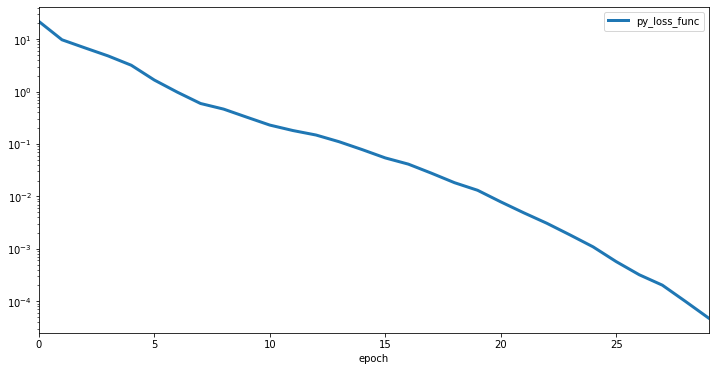

In [3]:
criterion = lambda y, y_hat: tf.reduce_mean(tf.square(y- y_hat))

model, history = train(
    model=LinearModel(num_units=[5,3,1], use_bias=True), 
    criterion=criterion,
    optimizer=optimizer)

history.columns = ['epoch', 'py_loss_func']
history.plot(x='epoch', y='py_loss_func', kind='line', logy=True, figsize=(12,6), linewidth=3)

Let's delete the loss function and see if backward pass still works or not

In [4]:
sample_indices = tf.convert_to_tensor(np.random.choice(range(65535), 1024))
x_batch, y_batch = tf.gather(x, sample_indices), tf.gather(y, sample_indices)
with tf.GradientTape() as tape:
    loss = criterion(y_batch, model(x_batch))
del criterion
print(criterion)    

NameError: name 'criterion' is not defined

In [5]:
gradients = tape.gradient(loss, model.variables)
print(gradients[0])
optimizer.apply_gradients(zip(gradients, model.variables))

tf.Tensor(
[[ 0.00000000e+00  1.08638094e-04  9.94438451e-05  0.00000000e+00
   6.97025753e-05]
 [ 0.00000000e+00 -1.35712355e-04 -1.24226761e-04  0.00000000e+00
  -8.70732620e-05]
 [ 0.00000000e+00  2.72340549e-05  2.49290460e-05  0.00000000e+00
   1.74732413e-05]
 [ 0.00000000e+00  1.80036877e-04  1.64799683e-04  0.00000000e+00
   1.15511968e-04]
 [ 0.00000000e+00  4.20951692e-05  3.85324820e-05  0.00000000e+00
   2.70083256e-05]
 [ 0.00000000e+00  6.32810232e-04  5.79253712e-04  0.00000000e+00
   4.06012579e-04]
 [ 0.00000000e+00 -3.78202822e-04 -3.46194429e-04  0.00000000e+00
  -2.42655908e-04]
 [ 0.00000000e+00  2.84304260e-05  2.60245288e-05  0.00000000e+00
   1.82410586e-05]
 [ 0.00000000e+00  1.16537255e-03  1.06674351e-03  0.00000000e+00
   7.47705810e-04]
 [ 0.00000000e+00  8.23932700e-04  7.54200562e-04  0.00000000e+00
   5.28637087e-04]], shape=(10, 5), dtype=float32)


<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1891>

### 2 `tf.keras.losses`  

There are two forms of loss functions shipped with tensorflow, `function` or `class`, and the class is just a wrapper around the functional form with an added reduction method. And the functional form is ensenssially the same as our lambda function defined earlier. Either way, both should work just the same as with our python loss function. 

One clear advantage with a loss function object, is that it can be serialized and deserialized. Other than that, there should be no difference in terms of guiding the path of gradient descent optimization.  

In [6]:
criterion = lambda y, y_hat: tf.reduce_mean(tf.square(y- y_hat))
criterion(y_batch, model(x_batch))

<tf.Tensor: id=119490, shape=(), dtype=float32, numpy=4.835384e-05>

In [7]:
tf.keras.losses.MeanSquaredError()(y_batch, model(x_batch))

<tf.Tensor: id=119513, shape=(), dtype=float32, numpy=4.835384e-05>

In [8]:
tf.reduce_mean(tf.keras.losses.mean_squared_error(y_batch, model(x_batch)))

<tf.Tensor: id=119521, shape=(), dtype=float32, numpy=4.835384e-05>

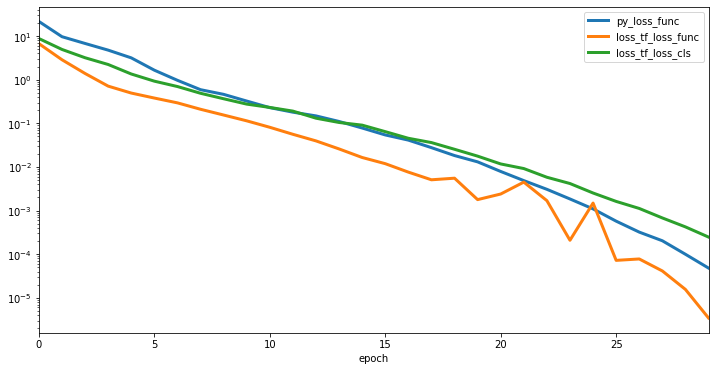

In [9]:
_, history_tf_loss_func = train(
    model=LinearModel(num_units=[5,3,1], use_bias=True), 
    criterion=lambda y, y_hat: tf.reduce_mean(tf.keras.losses.mean_squared_error(y, y_hat)),
    optimizer=optimizer)

_, history_tf_loss_class = train(
    model=LinearModel(num_units=[5,3,1], use_bias=True), 
    criterion=tf.keras.losses.MeanSquaredError(),
    optimizer=optimizer)


history['loss_tf_loss_func'] = history_tf_loss_func['loss']
history['loss_tf_loss_cls'] = history_tf_loss_class['loss']

history.plot(x='epoch', kind='line', logy=True, figsize=(12,6), linewidth=3)

In [10]:
history.tail()

,epoch,py_loss_func,loss_tf_loss_func,loss_tf_loss_cls
25,25,0.000571,0.000072,0.001620
26,26,0.000320,0.000078,0.001117
27,27,0.000203,0.000041,0.000677
28,28,0.000099,0.000016,0.000422
29,29,0.000048,0.000003,0.000247


Note that any difference you may see here is pretty much due to random number generator. Neural networks optimization can be quite sensitive to variable initializations, which will discuss later. 

### 3 Custom Loss  

One obvious way of writing custom loss function is with a python function, we know how to do it already. 

If the loss function contains some kind of hyperparameter of its own and/or we wish to be able to save/load the loss function, its better to implement it as a class.   

Below, we will implement the [Huber loss](https://en.wikipedia.org/wiki/Huber_loss) as an example in both functional form and as a subclass to `tf.keras.losses.Loss`.

In [11]:
def huber_loss(y_true, y_pred, delta):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    error = y_true - y_pred
    abs_error = tf.abs(error)
    mask = abs_error < delta
    squared_loss = tf.square(error) / 2
    linear_loss = delta * (abs_error - delta / 2)
    loss = tf.where(mask, squared_loss, linear_loss)
    return loss


class HuberLoss(tf.keras.losses.Loss):
    def __init__(self, delta, **kwargs):
        super().__init__(**kwargs)
        self.delta = delta

    def call(self, y_true, y_pred):
       return huber_loss(y_true, y_pred, self.delta)

    def get_config(self):
        config = super().get_config()
        return {**config, "delta": self.delta}

In [12]:
_, history_huber_func = train(
    model=LinearModel(num_units=[5,3,1], use_bias=True), 
    criterion=lambda y, y_hat: tf.reduce_mean(huber_loss(y, y_hat, 1)),
    optimizer=optimizer)

_, history_huber_class = train(
    model=LinearModel(num_units=[5,3,1], use_bias=True), 
    criterion=HuberLoss(delta=1),
    optimizer=optimizer)

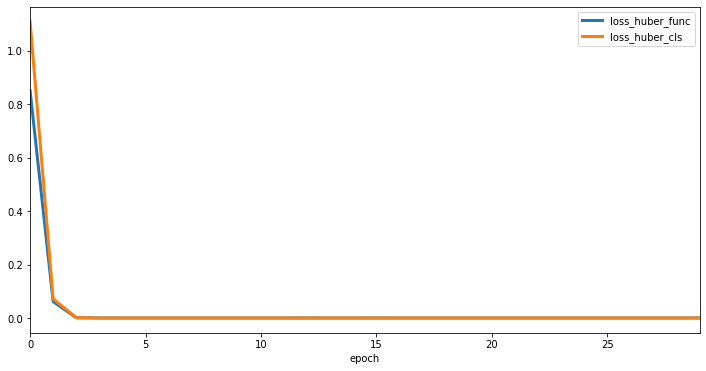

In [13]:
history['loss_huber_func'] = history_huber_func['loss']
history['loss_huber_cls'] = history_huber_class['loss']

history.plot(x='epoch', y=['loss_huber_func', 'loss_huber_cls'], kind='line', logy=False, figsize=(12,6), linewidth=3)

### 4 Multiple Losses

If there are multiple aspect that we wish the trained model to have, we can use multiple loss functions to guide the training. Lets see how it works. 

The first example here is not perticularly meaningful other than showing you it is doable to combine multiple losses to train a neural network. 

Below we implement a loss function that is a weighted combination of MSE and Huber. 

Typically with custom loss function that contains multiple components, it is better to keep track of the loss values from individual components, so that we can know what task/measure/desired property of the network is harder to archive/optimize for/obtain with the data and model archtucture we have. 

In [14]:
def train(model, optimizer, huber_delta=1, loss_weight=.5, batch_size=1024, num_epochs=30, record_steps=1):
    n = tf.shape(x).numpy()[0]
    steps_per_epoch = n // batch_size
    
    history = []
    for it in range(num_epochs):
        for bt in tqdm(range(steps_per_epoch), 
                       desc='Training epoch {}'.format(it + 1), 
                       leave=False):
            sample_indices = tf.convert_to_tensor(np.random.choice(range(n), batch_size))
            x_batch, y_batch = tf.gather(x, sample_indices), tf.gather(y, sample_indices)
            # forward pass to calculate loss
            with tf.GradientTape() as tape:
                y_hat_batch = model(x_batch)
                mse_loss_term = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_batch, y_hat_batch))
                huber_loss_term = tf.reduce_mean(huber_loss(y_batch, y_hat_batch, huber_delta))
                loss = loss_weight * mse_loss_term + (1 - loss_weight) * huber_loss_term

            # backward pass to calculate gradients
            gradients = tape.gradient(loss, model.variables)
            
            # use optimizer object to do update
            optimizer.apply_gradients(zip(gradients, model.variables))
            
        if not it % record_steps:    
            history.append({
                'epoch': it, 
                'loss': loss.numpy(),
                'mse_loss': mse_loss_term.numpy(),
                'huber_loss': huber_loss_term.numpy()
            })
            
    return model, pd.DataFrame(history)

_, history_combo_loss = train(model=LinearModel(num_units=[5,3,1], use_bias=True), optimizer=optimizer)

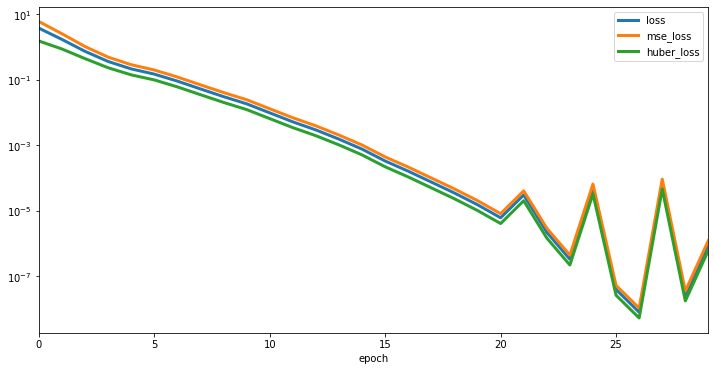

In [15]:
history_combo_loss.plot(x='epoch', kind='line', logy=True, figsize=(12,6), linewidth=3)

The above losses are based on data(data loss), we can also introduce a loss function that measures the complexity of the model(weight loss). When we optimize the model with both data loss and weight loss, we are saying that we want the model to do its job, but with less complexity. 

Here we are optimizing a network that has too much freedom to our problem, and we will use l1 weight loss to encourage the model to be more sparse.

In [16]:
def train(model, optimizer, penalty=1, batch_size=1024, num_epochs=30, record_steps=1):
    n = tf.shape(x).numpy()[0]
    steps_per_epoch = n // batch_size
    
    history = []
    for it in range(num_epochs):
        for bt in tqdm(range(steps_per_epoch), 
                       desc='Training epoch {}'.format(it + 1), 
                       leave=False):
            sample_indices = tf.convert_to_tensor(np.random.choice(range(n), batch_size))
            x_batch, y_batch = tf.gather(x, sample_indices), tf.gather(y, sample_indices)
            # forward pass to calculate loss
            with tf.GradientTape() as tape:
                y_hat_batch = model(x_batch)
                data_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_batch, y_hat_batch))
                weight_loss = tf.reduce_sum(list(map(tf.reduce_sum, map(tf.abs, model.variables))))
                loss = data_loss + penalty * weight_loss

            # backward pass to calculate gradients
            gradients = tape.gradient(loss, model.variables)
            
            # use optimizer object to do update
            optimizer.apply_gradients(zip(gradients, model.variables))
            
        if not it % record_steps:    
            history.append({
                'epoch': it, 
                'loss': loss.numpy(),
                'data_loss': data_loss.numpy(),
                'weight_loss': weight_loss.numpy()
            })
            
    return model, pd.DataFrame(history)

_, history_l1_regularized = train(model=LinearModel(num_units=[32,8,1], use_bias=True), optimizer=optimizer)

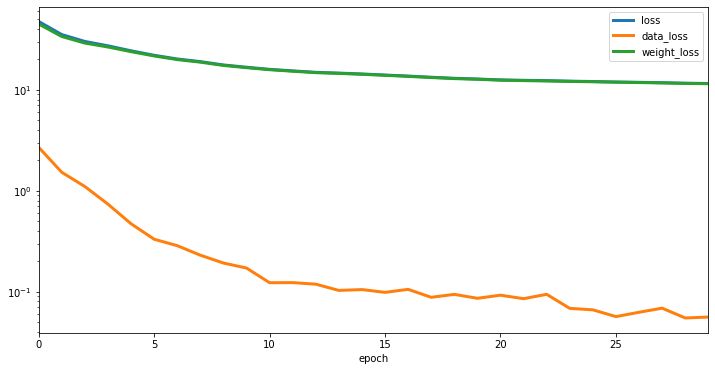

In [17]:
history_l1_regularized.plot(x='epoch', kind='line', logy=True, figsize=(12,6), linewidth=3)

In [18]:
history_l1_regularized.tail()

,epoch,loss,data_loss,weight_loss
25,25,11.964815,0.056602,11.908213
26,26,11.874362,0.062468,11.811894
27,27,11.774455,0.068636,11.705819
28,28,11.638570,0.054855,11.583714
29,29,11.559962,0.056009,11.503953


Yet another use case with multiple loss functions is with multi task models, where the model has multiple outputs, each is performing a different task and needs to be addressed differerntly. We will cover this topic later on. 